In [1]:
import pandas as pd
import numpy as np
from pybnesian import hc, CLGNetworkType, SemiparametricBNType, SemiparametricBN
#from drawdata import draw_scatter
import matplotlib.pyplot as plt
import math

from pymoo.core.problem import ElementwiseProblem

from pymoo.optimize import minimize

from bayesace.utils import *
from bayesace.algorithms.bayesace_algorithm import BayesACE
from bayesace.algorithms.face import FACE

from sklearn.preprocessing import StandardScaler, MinMaxScaler


In [2]:
df = pd.read_csv("toy-3class.csv")
df["class"] = df["z"].astype('category')
df = df.drop("z", axis = 1 )

feature_columns = [i for i in df.columns if i != "class"]
df[feature_columns] = StandardScaler().fit_transform(df[feature_columns].values)



learned = hc(df, bn_type = CLGNetworkType(), operators = ["arcs"], score = "validated-lik")
learned.fit(df)

naive = SemiparametricBN(df.columns)
feature_columns = [i for i in df.columns if i != "class"]
for i in [i for i in df.columns if i != "class"] :
    naive.add_arc("class", i)
learned_kde = hc(df, start = naive, operators = ["arcs", "node_type"], score = "validated-lik")
learned_kde.fit(df)



In [3]:
predict_class(df, learned)

,a,b,c
0,1.000000e+00,9.572975e-56,1.390909e-09
1,1.000000e+00,5.083611e-63,7.696461e-14
2,9.999996e-01,1.265553e-67,3.520504e-07
3,1.000000e+00,6.772657e-57,1.770983e-10
4,1.000000e+00,2.411502e-69,1.258256e-10
...,...,...,...
415,1.894030e-13,3.644321e-64,1.000000e+00
416,1.953863e-11,5.068296e-54,1.000000e+00
417,8.187773e-12,1.731237e-62,1.000000e+00
418,1.551465e-13,4.856500e-60,1.000000e+00


In [4]:
for i in learned.nodes() :
    print(i)
    print(learned_kde.cpd(i))

x
[HCKDE] P(x | y, class)
+-------+-------------------------------------------+
|       |                   x | y                   |
+-------+-------------------------------------------+
| class |                                           |
+-------+-------------------------------------------+
|   a   | [CKDE] P(x | y) = CKDE with 201 instances |
|   b   | [CKDE] P(x | y) = CKDE with 145 instances |
|   c   | [CKDE] P(x | y) = CKDE with 74 instances  |
+-------+-------------------------------------------+

y
[HCKDE] P(y | class)
+-------+---------------------------------------+
|       |                   y                   |
+-------+---------------------------------------+
| class |                                       |
+-------+---------------------------------------+
|   a   | [CKDE] P(y) = CKDE with 201 instances |
|   b   | [CKDE] P(y) = CKDE with 145 instances |
|   c   | [CKDE] P(y) = CKDE with 74 instances  |
+-------+---------------------------------------+

class
[Discre

In [5]:
instance = df.iloc[[0]]
instance["class"] = pd.Categorical(["a"], categories=learned.cpd("class").variable_values())
log_likelihood(instance,learned)

/tmp/ipykernel_441436/16804482.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  instance["class"] = pd.Categorical(["a"], categories=learned.cpd("class").variable_values())


array([-3.56347381])

In [13]:
n_vertex = 2
x_og = df.iloc[[0]]
bayesace = BayesACE(bayesian_network=learned, features= df.columns[:-1], n_vertex=n_vertex, chunks = 10, penalty=1, pop_size=100, likelihood_threshold=0.01, accuracy_threshold= 0.05, generations=20, verbose=False)
res = bayesace.run(x_og)
res_b = res

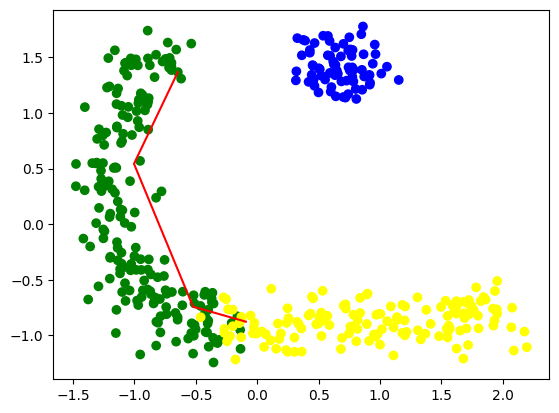

In [12]:
x_1 = x_og.drop("class",axis = 1)
df_vertex = res_b.path
to_plot = df.drop("class", axis = 1)
colours = df["class"].to_numpy()
colours[colours == "a"] = "green"
colours[colours == "b"] = "yellow"
colours[colours == "c"] = "blue"
plt.scatter(to_plot["x"],to_plot["y"], color = colours)
plt.plot(df_vertex.x,df_vertex.y,color = "red")
#plt.show()
plt.savefig("bace.png")

In [8]:
x_og = df.iloc[[0]]
face = FACE(bayesian_network=learned, features= df.columns[:-1], dataset=df.drop("class", axis = 1), graph_type = "epsilon", chunks = 10, penalty=1, distance_threshold=0.75, accuracy_threshold= 0.05,  likelihood_threshold=0.35, verbose = False)
res = face.run(x_og)

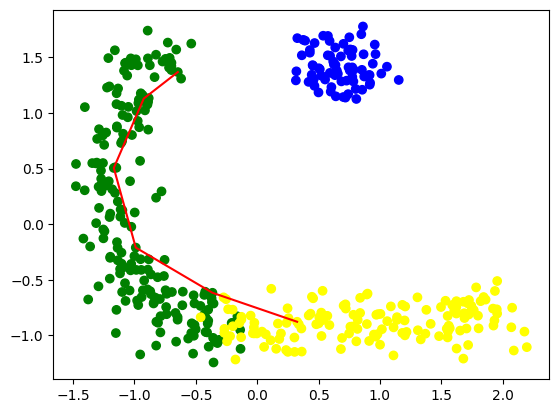

In [9]:
x_1 = x_og.drop("class",axis = 1)
df_vertex = res.path
to_plot = df.drop("class", axis = 1)
colours = df["class"].to_numpy()
colours[colours == "a"] = "green"
colours[colours == "b"] = "yellow"
colours[colours == "c"] = "blue"
plt.scatter(to_plot["x"],to_plot["y"], color = colours)
plt.plot(df_vertex.x,df_vertex.y,color = "red")
#plt.show()
plt.savefig("face.png")

In [58]:
sum(abs(res.path-res_b.path))

TypeError: unsupported operand type(s) for +: 'int' and 'str'

In [62]:
path_likelihood_length(res.path, learned) - path_likelihood_length(res_b.path, learned)

-5.756160942856777